In [97]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml as dml
import dask_ml.model_selection as dcv
from dask.diagnostics import ProgressBar

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import random
import imblearn as imblearn
from sklearn.preprocessing import MinMaxScaler

import Modeling_Helper
import Processing



import shap
shap.initjs()


import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
import statsmodels.api as sm


In [17]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'person',
    'offer_id',
    'time_received',
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]

In [18]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
    'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [19]:
for i in cat_vars:
    y = pd.get_dummies(modeling_data[i], prefix=i, drop_first=True)
    y = y.astype('int64')
    features = features + y.columns.tolist()
    features = [x for x in features if x != i]
    modeling_data = pd.concat([modeling_data, y], axis=1)

In [20]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()
print(len(train_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(modeling_data[y_var]), np.mean(train_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.7981579560973985 0.20184204390260152
0.029079644249025684 0.029046595580410242 0.029210330885386583
33.42744252873563


In [21]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(train_df.loc[:, features])
train_df.loc[: , features] = scaler.transform(train_df.loc[: , features])
val_df.loc[: , features] = scaler.transform(val_df.loc[: , features])
test_df.loc[: , features] = scaler.transform(test_df.loc[: , features])

NameError: name 'val_df' is not defined

In [ ]:
cor_df = Processing.correlation_map(train_val_df, features)

In [22]:
sm = imblearn.over_sampling.RandomOverSampler(random_state=2021)
X_train_res, y_train_res = sm.fit_resample(train_df[features], train_df[y_var].ravel())
X_train_res[y_var] = y_train_res

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (93062, 43)
After OverSampling, the shape of train_y: (93062,) 

After OverSampling, counts of label '1': 46531
After OverSampling, counts of label '0': 46531


In [23]:
import statsmodels.api as sm
X_train_res = sm.add_constant(X_train_res, has_constant='add')
logit_model=sm.Logit(X_train_res[y_var], X_train_res[['const']+features])
logit_model=logit_model.fit()
print(logit_model.summary2())

         Current function value: 0.607410
         Iterations: 35
                                              Results: Logit
Model:                             Logit                         Pseudo R-squared:              0.124      
Dependent Variable:                successful_offer              AIC:                           113117.6194
Date:                              2021-11-24 18:05              BIC:                           113419.7321
No. Observations:                  93062                         Log-Likelihood:                -56527.    
Df Model:                          31                            LL-Null:                       -64506.    
Df Residuals:                      93030                         LLR p-value:                   0.0000     
Converged:                         0.0000                        Scale:                         1.0000     
No. Iterations:                    35.0000                                                                 
---------

Maximum Likelihood optimization failed to converge. Check mle_retvals


************** Performance: Train Set **************** 

Accuracy: 0.67
Precision: 0.65
Recall: 0.71
F1: 0.68


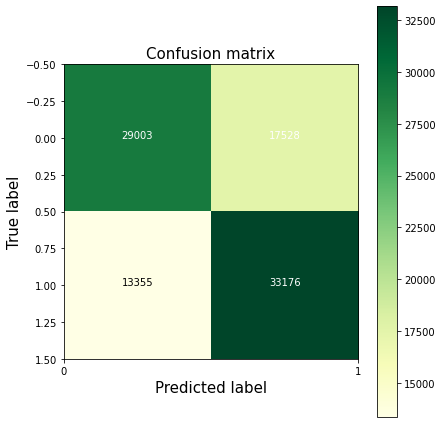

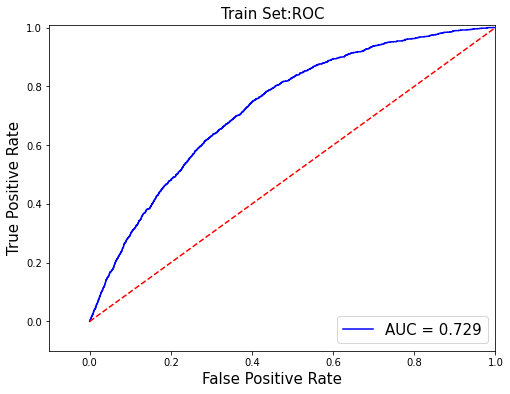

In [24]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(logit_model, X_train_res, ['const']+features, y_var, 'Train Set', prob = False)
perf_analysis.perf_analysis()

************** Performance: Test Set **************** 

Accuracy: 0.03
Precision: 0.03
Recall: 1.0
F1: 0.06


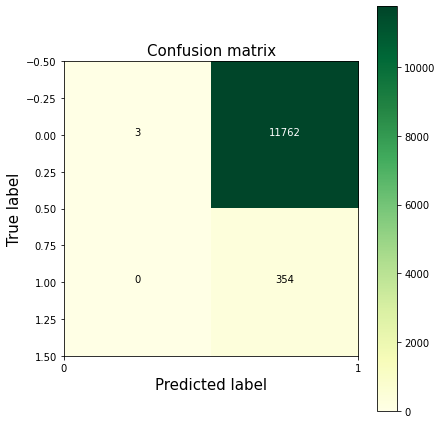

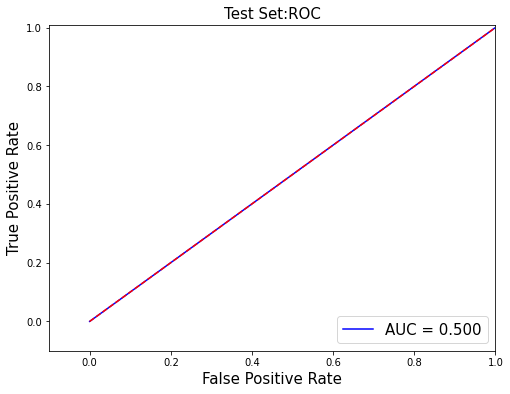

In [25]:
test_df = sm.add_constant(test_df, has_constant='add')
perf_analysis = Modeling_Helper.PerformanceAnalysis(logit_model, test_df, ['const']+features, y_var, 'Test Set', prob = False)
perf_analysis.perf_analysis()

In [33]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'person',
    'offer_id',
    'time_received',
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]

In [34]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
    'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [36]:
for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [37]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 2021)
train_val_df, train_df, val_df, test_df = data_split.split_data()
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(modeling_data[y_var]), np.mean(train_val_df[y_var]), np.mean(test_df[y_var]))
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(val_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.7981579560973985 0.20184204390260152
0.029079644249025684 0.029046595580410242 0.029210330885386583
0.7981579560973985 0.20184204390260152
0.029380355794024954 0.02770199370409234 0.029210330885386583
33.0363475177305


In [38]:
train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
val_data = lgb.Dataset(val_df[features], label=val_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

In [43]:
# mc = [1 for f in cont_vars]+[None for f in cat_vars]


params = {'objective': "binary", 'metric': ['binary_logloss', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
              
            'max_depth':5, 
            'num_leaves':10, 
            'learning_rate': 0.2,
            'num_iterations':1000,
            'min_data_in_leaf': 300,
            'max_bin':100,
            'scale_pos_weight':scale_pos_weight_val
#          'monotone_constraints': mc
         }

gbm_model = lgb.train(params,
            train_data,
#             valid_sets=[val_data],
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
#             early_stopping_rounds=400,
                     )

Found `num_iterations` in params. Will use it instead of argument
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


************** Performance: Train Set **************** 

Accuracy: 0.9
Precision: 0.23
Recall: 1.0
F1: 0.37


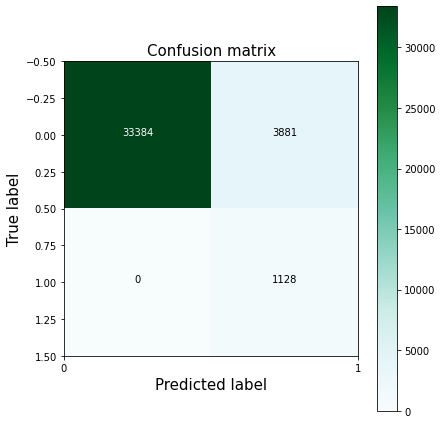

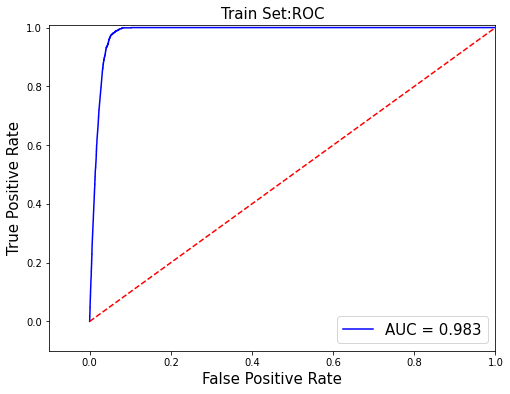

************** Performance: Val Set **************** 

Accuracy: 0.86
Precision: 0.06
Recall: 0.26
F1: 0.09


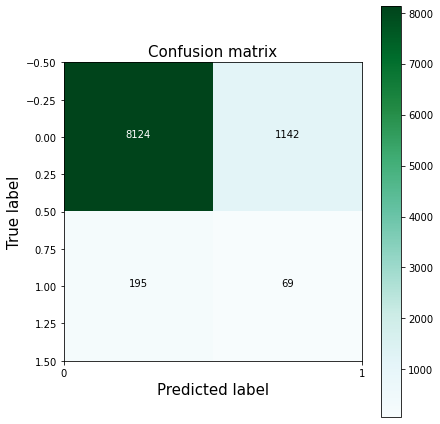

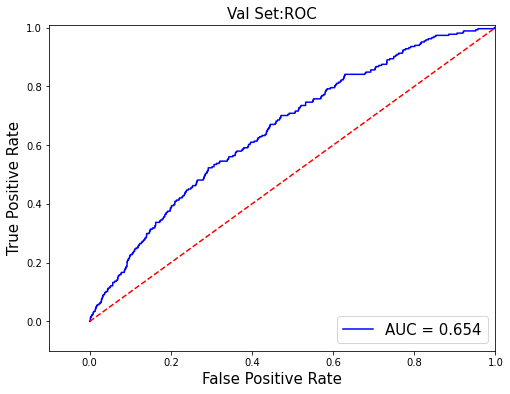

In [46]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, train_df, features, y_var, 'Train Set', prob = False)
perf_analysis.perf_analysis()
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, val_df, features, y_var, 'Val Set', prob = False)
perf_analysis.perf_analysis()

In [47]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


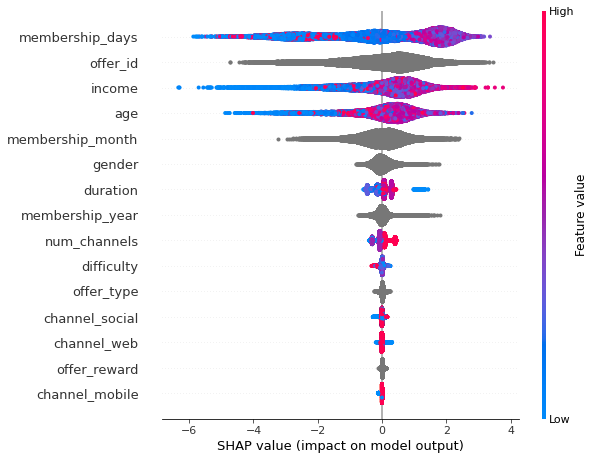

In [48]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)

In [54]:
modeling_data = modeling_data.sort_values(by = ['person', 'time_received']).reset_index(drop = True)
modeling_data['num_offers'] = modeling_data.groupby('person')['time_received'].transform(lambda group: group.astype('category').cat.codes + 1)
modeling_data['membership_month_sin'] = np.sin(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_month_cos'] = np.cos(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_days_X_income'] = modeling_data['membership_days']*modeling_data['income']
modeling_data['num_channels_X_income'] = modeling_data['num_channels']*modeling_data['income']
modeling_data['age_X_income'] = modeling_data['age']*modeling_data['income']

In [55]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'num_offers',
    'membership_days_X_income',
    'num_channels_X_income',
    'age_X_income',
    'membership_month_sin',
    'membership_month_cos',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
#     'difficulty',
    'gender', 
#     'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [56]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 2021)
train_val_df, train_df, val_df, test_df = data_split.split_data()
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(modeling_data[y_var]), np.mean(train_val_df[y_var]), np.mean(test_df[y_var]))
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(val_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.7984077812198128 0.2015922187801872
0.029079644249025684 0.029100087613167007 0.02899867812293457
0.7984077812198128 0.2015922187801872
0.029119373776908025 0.029023197753042754 0.02899867812293457
33.34139784946237


In [77]:
# best = {'learning_rate': 0.0027995242034568827,
#  'num_leaves': 26,
#  'colsample_bytree': 0.9995686849369345,
#  'reg_alpha': 0.13449436788184574,
#  'reg_lambda': 0.9769689983386204,
#  'max_depth': 22,
#  'min_child_samples': 596,
#  'subsample': 0.5521506693185276}

# gbm_model = lgb.LGBMClassifier(objective = "binary", 
#                                metric = ['auc', 'binary_error'], 
#                                random_state=2021, 
#                                silent=True, 
#                                n_jobs=-1, 
#                                n_estimators=400, 
#                                scale_pos_weight = scale_pos_weight_val,
#                                learning_rate = best['learning_rate'],
#                                num_leaves = best['num_leaves'],
#                                colsample_bytree = best['colsample_bytree'],
#                                reg_alpha = best['reg_alpha'],
#                                reg_lambda =  best['reg_lambda'],
#                                max_depth =  best['max_depth'],
#                                min_child_samples =  best['min_child_samples'],
#                                subsample =  best['subsample']
                               
                               
#                           )

gbm_model = lgb.LGBMClassifier(objective = "binary", 
                               metric = ['auc', 'binary_error'], 
                               random_state=2021, 
                               silent=True, 
                               n_jobs=-1, 
                               n_estimators=400, 
                               scale_pos_weight = scale_pos_weight_val,
                               learning_rate = 0.0027995242034568827,
                               num_leaves = 26,
                               colsample_bytree = 0.9995686849369345,
                               reg_alpha = 0.13449436788184574,
                               reg_lambda = 0.9769689983386204,
                               max_depth = 22,
                               min_child_samples =  596,
                               subsample = 0.5521506693185276
                               
                               
                          )

gbm_model.fit(train_val_df[features], train_val_df[y_var], )

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


LGBMClassifier(colsample_bytree=0.9995686849369345,
               learning_rate=0.0027995242034568827, max_depth=22,
               metric=['auc', 'binary_error'], min_child_samples=596,
               n_estimators=400, num_leaves=26, objective='binary',
               random_state=2021, reg_alpha=0.13449436788184574,
               reg_lambda=0.9769689983386204,
               scale_pos_weight=33.34139784946237, silent=True,
               subsample=0.5521506693185276)

************** Performance: Train Set **************** 

Accuracy: 0.91
Precision: 0.11
Recall: 0.31
F1: 0.16


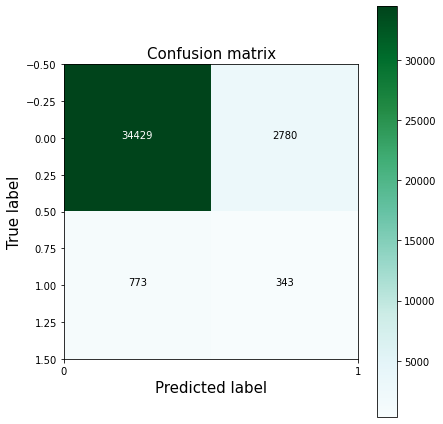

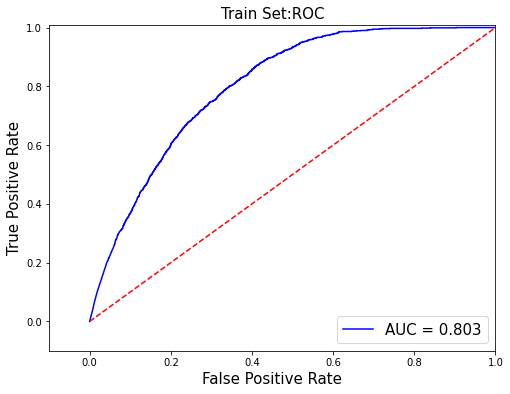

************** Performance: Val Set **************** 

Accuracy: 0.91
Precision: 0.1
Recall: 0.25
F1: 0.14


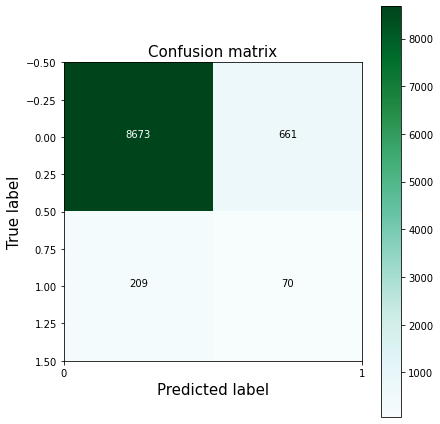

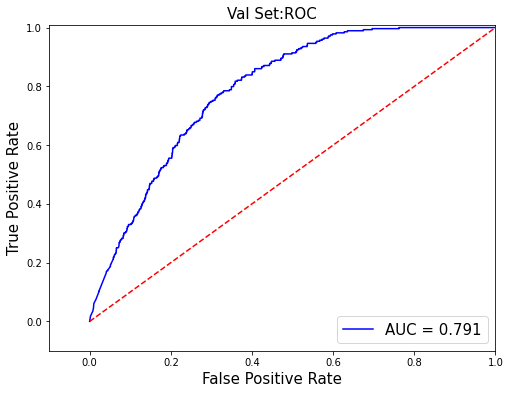

In [79]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, train_df, features, y_var, 'Train Set', prob = True)
perf_analysis.perf_analysis()
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, val_df, features, y_var, 'Val Set', prob = True)
perf_analysis.perf_analysis()

In [57]:
train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
val_data = lgb.Dataset(val_df[features], label=val_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

In [58]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
class BayesianOpt:
    def __init__(
        self,
        train_data,
        features,
        y_var,
        scale_pos_weight_val,
        hyperparameter_ranges, 
        n_trials,
        random_seed
    ):
        """
        Initialises DataPrep
        This class is used to prepare the data

        :param portfolio_path: (str) path to portfolio data
        :param profile_path: (str) path to profile data
        :param transcript_path: (str) path to transcript

        """

        self.train_data = train_data
        self.features = features
        self.y_var = y_var
        self.scale_pos_weight_val = scale_pos_weight_val
        self.hyperparameter_ranges = hyperparameter_ranges
        self.n_trials = n_trials
        self.random_seed = random_seed
        sampler = TPESampler(seed=self.random_seed)  # Make the sampler behave in a deterministic way.
        study = optuna.create_study(sampler =sampler, direction="maximize")
        
        
    def objective(self, trial):
    
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.4, log = True)
        num_leaves = trial.suggest_int("num_leaves", 2, 60)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.2,1)
        reg_alpha = trial.suggest_float("reg_alpha", 1e-2, 5, log = True)
        reg_lambda = trial.suggest_float("reg_lambda", 1e-2, 5, log = True)
        max_depth = trial.suggest_int("max_depth", 2, 30)
        min_child_samples = trial.suggest_int("min_child_samples", 50, 600)
        subsample = trial.suggest_float("subsample", 0.2,1)
        n_estimators = trial.suggest_int("n_estimators", 500, 2000) 

        param ={
            'learning_rate': [learning_rate],
            'num_leaves': [num_leaves],
            'colsample_bytree': [colsample_bytree],
            'reg_alpha': [reg_alpha],
            'reg_lambda': [reg_lambda],
            'max_depth':[max_depth],
            'min_child_samples': [min_child_samples], 
            'subsample': [subsample],
            'n_estimators': [n_estimators],
            'verbose': [-1]
                }


        gbm_model = lgb.LGBMClassifier(objective = "binary", 
                                       metric = ["auc", "binary_error"], 
                                       random_state=2021, 
                                       n_jobs=-1, 
                                       scale_pos_weight = scale_pos_weight_val,
                                  )
        gbm_gs = dcv.GridSearchCV(
            estimator=gbm_model, param_grid=param, 
            scoring='f1',
            cv=5,
            refit=True,
        )

        gbm_gs.fit(train_val_df[features], train_val_df[y_var], )

        return gbm_gs.best_score_
    
    def run_optimization(self):
        study.optimize(objective,n_trials=self.n_trials)
        return study.best_params


In [93]:
sampler = TPESampler(seed=2021)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler = sampler, direction="maximize")
print(f"Sampler is {study.sampler.__class__.__name__}")

[I 2021-11-24 17:18:52,535] A new study created in memory with name: no-name-0fe920e1-4b9c-47d4-b6b5-30f4a05bd53c


Sampler is TPESampler


In [94]:
def objective(trial):
    
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.4, log = True)
    num_leaves = trial.suggest_int("num_leaves", 2, 60)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2,1)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-2, 5, log = True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-2, 5, log = True)
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_child_samples = trial.suggest_int("min_child_samples", 50, 600)
    subsample = trial.suggest_float("subsample", 0.2,1)
    n_estimators = trial.suggest_int("n_estimators", 500, 2000) 

    param ={
        'learning_rate': [learning_rate],
        'num_leaves': [num_leaves],
        'colsample_bytree': [colsample_bytree],
        'reg_alpha': [reg_alpha],
        'reg_lambda': [reg_lambda],
        'max_depth':[max_depth],
        'min_child_samples': [min_child_samples], 
        'subsample': [subsample],
        'n_estimators': [n_estimators],
        'verbose': [-1]
            }
    
    
    gbm_model = lgb.LGBMClassifier(objective = "binary", 
                                   metric = ['auc', 'binary_error'], 
                                   random_state=2021, 
#                                    silent=True, 
                                   n_jobs=-1, 
#                                    n_estimators=400, 
                                   scale_pos_weight = scale_pos_weight_val,
#                                    verbose = -1
                              )
    gbm_gs = dcv.GridSearchCV(
        estimator=gbm_model, param_grid=param, 
        scoring='f1',
        cv=5,
        refit=True,
    )
    
#     with ProgressBar():
    gbm_gs.fit(train_val_df[features], train_val_df[y_var], )

    return gbm_gs.best_score_

In [95]:
study.optimize(objective,n_trials=100)

[I 2021-11-24 17:19:28,266] Trial 0 finished with value: 0.11543612981218308 and parameters: {'learning_rate': 0.0377391257196892, 'num_leaves': 45, 'colsample_bytree': 0.311157725382719, 'reg_alpha': 0.06980640530295552, 'reg_lambda': 4.915069954353206, 'max_depth': 5, 'min_child_samples': 148, 'subsample': 0.8023403430208751, 'n_estimators': 1493}. Best is trial 0 with value: 0.11543612981218308.
[I 2021-11-24 17:19:53,745] Trial 1 finished with value: 0.10941859646245865 and parameters: {'learning_rate': 0.10985555325894224, 'num_leaves': 7, 'colsample_bytree': 0.2468570280704288, 'reg_alpha': 3.958019320953226, 'reg_lambda': 0.4613919861163953, 'max_depth': 4, 'min_child_samples': 359, 'subsample': 0.6932197668943921, 'n_estimators': 1946}. Best is trial 0 with value: 0.11543612981218308.
[I 2021-11-24 17:20:28,813] Trial 2 finished with value: 0.11229504916346958 and parameters: {'learning_rate': 0.03121578259993011, 'num_leaves': 23, 'colsample_bytree': 0.5617161950316515, 'reg_a

[I 2021-11-24 17:32:32,145] Trial 20 finished with value: 0.11729377496051395 and parameters: {'learning_rate': 0.0027144204779683922, 'num_leaves': 13, 'colsample_bytree': 0.7693370874153554, 'reg_alpha': 0.21324923518833033, 'reg_lambda': 0.09259628164224384, 'max_depth': 10, 'min_child_samples': 198, 'subsample': 0.2227985038402308, 'n_estimators': 717}. Best is trial 18 with value: 0.14085329996792595.
[I 2021-11-24 17:32:44,104] Trial 21 finished with value: 0.14295858457731297 and parameters: {'learning_rate': 0.0025640511097735075, 'num_leaves': 10, 'colsample_bytree': 0.9962003572113031, 'reg_alpha': 0.20297450912334483, 'reg_lambda': 0.029219009600730664, 'max_depth': 21, 'min_child_samples': 99, 'subsample': 0.7352004049607801, 'n_estimators': 510}. Best is trial 21 with value: 0.14295858457731297.
[I 2021-11-24 17:33:04,035] Trial 22 finished with value: 0.13780774210522315 and parameters: {'learning_rate': 0.00268458879694401, 'num_leaves': 23, 'colsample_bytree': 0.9984957

[I 2021-11-24 17:38:31,325] Trial 40 finished with value: 0.10799330327541524 and parameters: {'learning_rate': 0.005727903461927988, 'num_leaves': 13, 'colsample_bytree': 0.6392418995756282, 'reg_alpha': 0.641066822490297, 'reg_lambda': 0.04593619050887089, 'max_depth': 24, 'min_child_samples': 196, 'subsample': 0.5717475038658211, 'n_estimators': 1145}. Best is trial 21 with value: 0.14295858457731297.
[I 2021-11-24 17:38:42,542] Trial 41 finished with value: 0.0 and parameters: {'learning_rate': 0.0014096352846714765, 'num_leaves': 5, 'colsample_bytree': 0.8906792197244421, 'reg_alpha': 0.2703402640404676, 'reg_lambda': 0.032712253564372275, 'max_depth': 20, 'min_child_samples': 77, 'subsample': 0.7645704753101715, 'n_estimators': 592}. Best is trial 21 with value: 0.14295858457731297.
[I 2021-11-24 17:38:57,641] Trial 42 finished with value: 0.1294048403158637 and parameters: {'learning_rate': 0.002035091252178855, 'num_leaves': 7, 'colsample_bytree': 0.8158470627982101, 'reg_alpha

[I 2021-11-24 17:46:01,358] Trial 60 finished with value: 0.13470068952726416 and parameters: {'learning_rate': 0.002345207884130961, 'num_leaves': 12, 'colsample_bytree': 0.9917975495941349, 'reg_alpha': 0.022831957520115565, 'reg_lambda': 0.010505475547257085, 'max_depth': 19, 'min_child_samples': 243, 'subsample': 0.9992900241907083, 'n_estimators': 626}. Best is trial 21 with value: 0.14295858457731297.
[I 2021-11-24 17:46:12,906] Trial 61 finished with value: 0.12423463075794516 and parameters: {'learning_rate': 0.003253583310848616, 'num_leaves': 9, 'colsample_bytree': 0.968122461453145, 'reg_alpha': 0.04542511952297671, 'reg_lambda': 0.020419488980392534, 'max_depth': 19, 'min_child_samples': 300, 'subsample': 0.9709588327571912, 'n_estimators': 535}. Best is trial 21 with value: 0.14295858457731297.
[I 2021-11-24 17:46:21,508] Trial 62 finished with value: 0.0 and parameters: {'learning_rate': 0.0013445487324401984, 'num_leaves': 4, 'colsample_bytree': 0.921361349875932, 'reg_a

[I 2021-11-24 17:52:34,151] Trial 80 finished with value: 0.1385674913061557 and parameters: {'learning_rate': 0.0020947182725317465, 'num_leaves': 14, 'colsample_bytree': 0.8673830212747115, 'reg_alpha': 0.016480268613800694, 'reg_lambda': 0.8274761749235776, 'max_depth': 18, 'min_child_samples': 285, 'subsample': 0.9999389008966727, 'n_estimators': 632}. Best is trial 68 with value: 0.14683764035557814.
[I 2021-11-24 17:52:50,073] Trial 81 finished with value: 0.12271763836149041 and parameters: {'learning_rate': 0.003319705037341021, 'num_leaves': 12, 'colsample_bytree': 0.818591061403159, 'reg_alpha': 0.05282869473919403, 'reg_lambda': 0.019305468028520376, 'max_depth': 13, 'min_child_samples': 230, 'subsample': 0.9106800797747749, 'n_estimators': 532}. Best is trial 68 with value: 0.14683764035557814.
[I 2021-11-24 17:53:02,217] Trial 82 finished with value: 0.13202362654972952 and parameters: {'learning_rate': 0.0027513763805936493, 'num_leaves': 6, 'colsample_bytree': 0.74001975

In [96]:
study.best_params

{'learning_rate': 0.0019851569148929783,
 'num_leaves': 16,
 'colsample_bytree': 0.787630607386268,
 'reg_alpha': 0.012750034555401552,
 'reg_lambda': 0.01515880368474774,
 'max_depth': 11,
 'min_child_samples': 350,
 'subsample': 0.9694414702328392,
 'n_estimators': 594}